# Ph.D. Course on "Advanced Machine Learning" August 23rd, 2024
## - Physics-Informed Machine Learning and Surrogate Modelling

This notebook is a part of exercises in the PhD Course that complement the lecture. 

To make sure your environment is setup to perform the exercises please visit

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; https://github.com/apengsigkarup

and follow the instructions for installing the environment.

If you have not already done so, please download all the data files and codes from this github repository and report any errors or issues with the materials to Allan Peter Engsig-Karup (apek@dtu.dk).

### Python modules needed

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
import platform

### Detect device

In [43]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Check for ARM architecture
architecture = platform.machine()
if 'arm' in architecture or 'aarch' in architecture:
    print("Architecture: ARM")
else:
    print(f"Architecture: {architecture}")

# Optional: More detailed GPU check
if device == "cuda":
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# Check for CPU information
cpu_info = platform.processor()
if cpu_info:
    print(f"CPU: {cpu_info}")
else:
    print("CPU information not available.")


Device: cpu
Architecture: ARM
CPU: arm


### Define Precision used in PyTorch

In [44]:
# Set default tensor type in PyTorch to float64 precision
torch.set_default_dtype(torch.float32)

### Define seed for deterministic (reproducible) calculations while testing

In [45]:
# for reproducibility, define a seed manually
seed = 28 # 21 # 13
torch.manual_seed(seed)
#random.seed(seed)
np.random.seed(seed)

### For storing figures

In [46]:
# Define the relative path
dirpath = '/Users/apek/Dropbox/Latex/Teaching/02901 PhD school - Advanced Machine Learning/Lecture/figures/' 
# relative_path = dirpath + filename 

## Exercise 05b: Getting Started

The purpose of this notebook is gain some experiences with setting up Universal Physics-Informed Neural Networks that utilize theUPINN approach combined with choice of neural network architecture for tasks such as
- finding approximate solutions of systems
- discovery of hidden physics / model corrections
- generalize to recover solutions outside the range of data
- get experience refining neural network architectures

To prepare for the exercises we define the Lotka-Volterra system, choose it's parameter and solve it numerically to produce (synthetic) data for training a neural network to recover the missing dynamics of an incomplete (nonlinear) model.

In [47]:
# Define the Lotka-Volterra system
def lotka_volterra(x, t, alpha, beta, gamma, delta):
    x1, x2 = x
    x1_dot = alpha * x1 - beta * x1 * x2
    x2_dot = delta * x1 * x2 - gamma * x2
    return [x1_dot, x2_dot]

def incomplete_lotka_volterra(x, t, alpha, beta, gamma, delta):
    x1, x2 = x
    x1_dot = alpha * x1 - beta * x1 * x2
    x2_dot = 0.0*delta * x1 * x2 - gamma * x2 # remove the delta term by zeroing it out
    return [x1_dot, x2_dot]

# Generate the train and test data
def generate_data(p, t, alpha, beta, gamma, delta, x0 = [1., 1.]):
    n = t.shape[0]
    x = np.zeros((n, 2))
    for i in range(n):
        x[i, :] = odeint(lotka_volterra, x0, [0, t[i]], args=(alpha, beta, gamma, delta))[-1, :]

    # Train data
    n_train = int(n * p)
    t_train = t[:n_train].reshape(-1, 1)
    x_train = x[:n_train]

    # Test data
    t_test = t[n_train:].reshape(-1, 1)
    x_test = x[n_train:]

    # Output also all data
    return t_train, x_train, t_test, x_test, t[:].reshape(-1, 1), x[:]

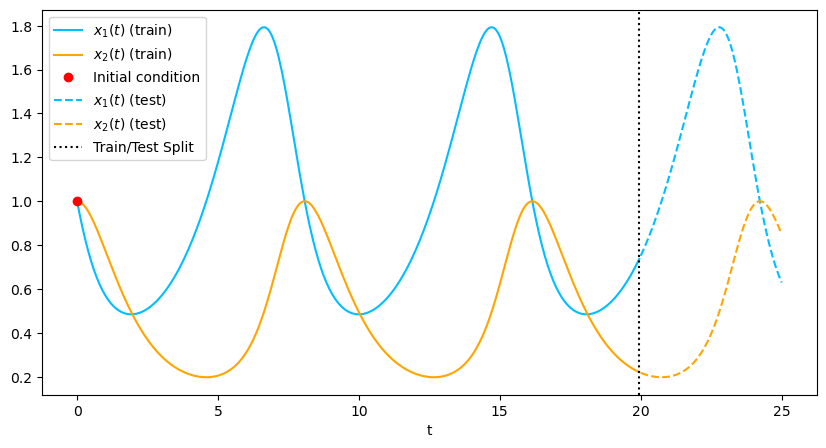

In [48]:
# Parameters for the data generation
t_steps = 501
t_span = [0, 25]
t = np.linspace(t_span[0], t_span[1], t_steps)

# Train - Test split ratio of data
p_split = 0.8 

# Select true parameters
alpha_true, beta_true, gamma_true, delta_true = .66, 4/3, 1., 1.

# Generate train - test data
t_train, x_train, t_test, x_test, t_all, x_all = generate_data(p_split, t, alpha_true, beta_true, gamma_true, delta_true)
#t_train = t_train.astype(np.float32)
#x_train = x_train.astype(np.float32)

# Plot the train and test data
plt.figure(figsize=(10, 5))
plt.plot(t_train, x_train[:, 0], color='deepskyblue', label='$x_1(t)$ (train)')
plt.plot(t_train, x_train[:, 1], color='orange', label='$x_2(t)$ (train)')
plt.plot(0,1,'o',color="red",label='Initial condition')
plt.plot(t_test, x_test[:, 0], color='deepskyblue', linestyle='--',label='$x_1(t)$ (test)')
plt.plot(t_test, x_test[:, 1], color='orange', linestyle='--',label='$x_2(t)$ (test)')
plt.axvline(t_train[-1], color='k', linestyle=':', label='Train/Test Split')
plt.xlabel('t')
#plt.ylabel('x')
plt.legend()
filename = 'UPINN_Lotka_Volterra01a.png'
full_path = dirpath + filename
plt.savefig(full_path)
plt.show()
# Store for re-use
t_train_orig = t_train
x_train_orig = x_train

### Exercise : Lotka-Volterra recover hidden dynamics using UPINN (Physics-Informed)

In this exercise the task is to recover hidden dynamics with the help from time series data using a Universal Physics-Informed Neural Network (UPINN) approach.

Next, define two classes UNet and GNet for approximating using a neural network that solution u(t) to the initial value problem (IVP) as well as the missing dynamics G(t), respectively. In these classes we should choose the hyperparameters, activation functions, initialize weights of the layers.

In [49]:
class PhysicalNormalization(nn.Module):
    def __init__(self, means, stds):
        super(PhysicalNormalization, self).__init__()
        self.means = torch.tensor(means)
        self.stds = torch.tensor(stds)
        
    def forward(self, x):
        return <DEFINE THIS>

def forward(self, x):
    x = self.normalization_layer(x)
    <DEFINE THIS>
    return u

# Define the neural network for u(t) : R -> R^2, 
class UNet(nn.Module):
    def __init__(self, hidden_units):
        super(UNet, self).__init__() 

        # Define network layers, here a fully-connected network, 1 input and 2 outputs
        <DEFINE THIS>

        # Choose activation function for the layer transformations
        <DEFINE THIS>
        # Choose activation function for the output layer
        <DEFINE THIS>

        # Weight initialization
        self.initialize_weights()        

    def initialize_weights(self):
        # Apply Xavier initialization to each layer
        nn.init.xavier_normal_(self.linear_1.weight)
        nn.init.xavier_normal_(self.linear_2.weight)
        nn.init.xavier_normal_(self.linear_3.weight)
        nn.init.xavier_normal_(self.linear_4.weight)
        nn.init.xavier_normal_(self.linear_5.weight)

        # Initialize biases to zero
        nn.init.constant_(self.linear_1.bias, 0)
        nn.init.constant_(self.linear_2.bias, 0)
        nn.init.constant_(self.linear_3.bias, 0)
        nn.init.constant_(self.linear_4.bias, 0)
        nn.init.constant_(self.linear_5.bias, 0)
        
    def forward(self, t):
        # Forward pass
        <DEFINE THIS>
        return u
    
# Define the neural network for unknown function G(t) : R^2 -> R^2, 
class GNet(nn.Module):
    def __init__(self, hidden_units):
        super(GNet, self).__init__() 

        # Choose activation function for the layer transformations
        <DEFINE THIS>
        # Choose activation function for the output layer
        <DEFINE THIS>

        # Weight initialization
        self.initialize_weights()        

        self.means = 0
        self.stds = 2
        # Example usage in your GNet class
        self.normalization_layer = PhysicalNormalization(self.means, self.stds)

    def initialize_weights(self):
        # Apply Xavier initialization to each layer
        nn.init.xavier_normal_(self.linear_1.weight)
        nn.init.xavier_normal_(self.linear_2.weight)
        nn.init.xavier_normal_(self.linear_3.weight)
        nn.init.xavier_normal_(self.linear_4.weight)
        nn.init.xavier_normal_(self.linear_5.weight)

        # Initialize biases to zero
        nn.init.constant_(self.linear_1.bias, 0)
        nn.init.constant_(self.linear_2.bias, 0)
        nn.init.constant_(self.linear_3.bias, 0)
        nn.init.constant_(self.linear_4.bias, 0)
        nn.init.constant_(self.linear_5.bias, 0)

    def freeze_weights(self):
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Normalize input values to have mean 0 and variance 1
        x = self.normalization_layer(x)
        <DEFINE THIS>
        return u

Define a physics-informed neural network (PINN) class that initializes the neural networks and store the model parameters to be used in defining the loss function "loss_fn" within the class. This class needs both a "__init__" function, a "forward" function and a "loss_fn" function.

# Define the PINN model


In [50]:
# Define the PINN model
class PINN(torch.nn.Module):
    def __init__(self, hidden_units_u,hidden_units_G):
        super(PINN, self).__init__()

        self.Unet = UNet(hidden_units_u)
        self.Gnet = GNet(hidden_units_G)
        
        # Store model parameters (here fixed)
        self.alpha = alpha_true
        self.beta  = beta_true
        self.gamma = gamma_true
        self.delta = delta_true
        # Time normalization parameters
        self.t_min = 0 #t_min
        self.t_max = 25 #t_max

    def forward(self, t):
        # Normalize time input
        t_normalized = <DEFINE THIS> 
        # Pass through the network
        u_output = self.Unet(t_normalized) 
        G_output = self.Gnet(u_output) # changed G here
        return u_output, G_output

    def loss_fn(self, t, x):
        # Compute loss terms and return total loss (cost function) for step 1
        x_pred, G_pred = self.forward(t)

        x1 = x_pred[:, 0].reshape(-1, 1)
        x2 = x_pred[:, 1].reshape(-1, 1)

        G1 = G_pred[:, 0].reshape(-1, 1)
        G2 = G_pred[:, 1].reshape(-1, 1)

        x1_t = torch.autograd.grad(x1, t, torch.ones_like(x1), create_graph=True)[0]
        x2_t = torch.autograd.grad(x2, t, torch.ones_like(x2), create_graph=True)[0]

        f1 = self.alpha * x1 - self.beta * x2 * x1 - x1_t + G1
        # f2 = self.delta * x1 * x2 - self.gamma * x2 - x2_t # original
        f2 = <DEFINE THIS> # incomplete model with a neural network correction

        pde1_loss = 1./t.shape[0] * ( torch.sum(f1**2) ) # residual loss
        pde2_loss = 1./t.shape[0] * ( torch.sum(f2**2) ) # residual loss
        fun_loss  = 1./t.shape[0] * torch.sum((x_pred - x) ** 2) 

        loss = fun_loss + pde1_loss + pde2_loss
        
        pde1_loss_future = torch.tensor(0)
        pde2_loss_future = torch.tensor(0)
        return loss, fun_loss, pde1_loss, pde2_loss, pde1_loss_future, pde2_loss_future

    def loss_fn2(self, t, x, t_future):
        # Compute loss terms and return total loss (cost function)
        x_pred, G_pred = self.forward(t)

        x1 = x_pred[:, 0].reshape(-1, 1)
        x2 = x_pred[:, 1].reshape(-1, 1)

        G1 = G_pred[:, 0].reshape(-1, 1)
        G2 = G_pred[:, 1].reshape(-1, 1)

        x1_t = torch.autograd.grad(x1, t, torch.ones_like(x1), create_graph=True)[0]
        x2_t = torch.autograd.grad(x2, t, torch.ones_like(x2), create_graph=True)[0]

        x_pred_future, G_pred_future = self.forward(t_future)
        x1_future = x_pred_future[:, 0].reshape(-1, 1)
        x2_future = x_pred_future[:, 1].reshape(-1, 1)

        G1_future = G_pred_future[:, 0].reshape(-1, 1)
        G2_future = G_pred_future[:, 1].reshape(-1, 1)

        x1_t_future = torch.autograd.grad(x1_future, t_future, torch.ones_like(x1_future), create_graph=True)[0]
        x2_t_future = torch.autograd.grad(x2_future, t_future, torch.ones_like(x2_future), create_graph=True)[0]

        f1 = self.alpha * x1 - self.beta * x2 * x1 - x1_t + G1
        # f2 = self.delta * x1 * x2 - self.gamma * x2 - x2_t # original
        f2 = - <DEFINE THIS> # incomplete model with a neural network correction

        pde1_loss = 1./t.shape[0] * ( torch.sum(f1**2) ) # residual loss
        pde2_loss = 1./t.shape[0] * ( torch.sum(f2**2) ) # residual loss
        fun_loss  = 1./t.shape[0] * torch.sum((x_pred - x) ** 2) 

        # future loss terms
        f1_future = <DEFINE THIS>
        # f2 = self.delta * x1 * x2 - self.gamma * x2 - x2_t # original
        f2_future = <DEFINE THIS> # incomplete model with a neural network correction

        pde1_loss_future = 1./t.shape[0] * ( torch.sum(f1_future**2) ) # residual loss
        pde2_loss_future = 1./t.shape[0] * ( torch.sum(f2_future**2) ) # residual loss

        #loss = 10*fun_loss + pde1_loss + 2*pde2_loss + 10*pde1_loss_future + 10*2*pde2_loss_future
        loss = fun_loss + pde1_loss + pde2_loss + pde1_loss_future + pde2_loss_future
        return loss, fun_loss, pde1_loss, pde2_loss, pde1_loss_future, pde2_loss_future


Choose which mode is to be used in the following cell. If train=1 the model is to be trained (and stored) and otherwise loaded.

The training for the UPINN approach is based on two steps
- first train to find u(t) and G(u(t)) on the training data. When G(u(t)) is determined after 30.000 epochs the weights for Gnet is fixed
- then train by including also time points in the unseen range of the data and then use the G(u(t)) found in the first step to compute residuals for all equations to be satisfied for u(t) to be correct on the entire range of the time interval of interest.

In [51]:
train = 1

In [52]:
# Training loop
model = PINN(hidden_units_u=15,hidden_units_G=15)
optimizer = <DEFINE THIS>

epochs = 150000
batch_size = 1024
freeze_epoch = 30000 # Number of epochs after which to freeze the weights

losses = []
epoch_train_losses = []
epoch_train_fun_losses = []
epoch_train_pde1_losses = []
epoch_train_pde2_losses = []
epoch_train_pde1_losses_future = []
epoch_train_pde2_losses_future = []

t_train = t_train_orig[0::10]
x_train = x_train_orig[0::10]

# Training data
t_train_tensor = torch.tensor(t_train, dtype=torch.float32, requires_grad=True)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)
t_test_tensor  = torch.tensor(t_test, dtype=torch.float32, requires_grad=True)

def train_network(model):
    for e in range(epochs+1):
        losses = []
        fun_losses = []
        pde1_losses = []
        pde2_losses = []
        pde1_losses_future = []
        pde2_losses_future = []
        # Split data in chunks according to batch size
        for i in range(0, t_train_tensor.shape[0], batch_size):
            optimizer.zero_grad()

            if e == freeze_epoch:
                model.Gnet.freeze_weights()    
                print("Gnet frozen") 

            if e <= freeze_epoch:
                loss, fun_loss, pde1_loss, pde2_loss, pde1_loss_future, pde2_loss_future = model.loss_fn(t_train_tensor[i:i+batch_size], x_train_tensor[i:i+batch_size])
            else: # try and generalize by fixing Gnet weigths
                loss, fun_loss, pde1_loss, pde2_loss, pde1_loss_future, pde2_loss_future = model.loss_fn2(t_train_tensor[i:i+batch_size], x_train_tensor[i:i+batch_size],t_test_tensor)

            loss.backward()            
            optimizer.step()

            losses.append(loss.item())
            fun_losses.append(fun_loss.item())
            pde1_losses.append(pde1_loss.item())
            pde2_losses.append(pde2_loss.item())
            pde1_losses_future.append(pde1_loss_future.item())
            pde2_losses_future.append(pde2_loss_future.item())

        epoch_train_losses.append(np.mean(losses))
        epoch_train_fun_losses.append(np.mean(fun_losses))
        epoch_train_pde1_losses.append(np.mean(pde1_losses))
        epoch_train_pde2_losses.append(np.mean(pde2_losses))
        epoch_train_pde1_losses_future.append(np.mean(pde1_losses_future))
        epoch_train_pde2_losses_future.append(np.mean(pde2_losses_future))

        if e % 250 == 0:
            print(f"Iteration {e}, loss={epoch_train_losses[-1]}")

if train:
    train_network(model)
    # Save the entire model
    torch.save(model, 'lotka-volterra.pth')
    print("Model is saved.")
else:
    model = torch.load('lotka-volterra.pth')
    print("Model is loaded.")

Iteration 0, loss=0.8219940066337585
Iteration 250, loss=0.26622074842453003
Iteration 500, loss=0.25039443373680115
Iteration 750, loss=0.2127227485179901
Iteration 1000, loss=0.16599075496196747
Iteration 1250, loss=0.04616015776991844
Iteration 1500, loss=0.01538567803800106
Iteration 1750, loss=0.007913084700703621
Iteration 2000, loss=0.003988155163824558
Iteration 2250, loss=0.0022039618343114853
Iteration 2500, loss=0.0014048583107069135
Iteration 2750, loss=0.0009531742543913424
Iteration 3000, loss=0.0006315440405160189
Iteration 3250, loss=0.00044633354991674423
Iteration 3500, loss=0.0003367238095961511
Iteration 3750, loss=0.00027146656066179276
Iteration 4000, loss=0.00022667270968668163
Iteration 4250, loss=0.00019375608826521784
Iteration 4500, loss=0.00022807737695984542
Iteration 4750, loss=0.00014740656479261816
Iteration 5000, loss=0.00012922781752422452
Iteration 5250, loss=0.00011623324098763987
Iteration 5500, loss=0.00012125115608796477
Iteration 5750, loss=0.000

Check how is the model defined.

In [ ]:
print(model)

PINN(
  (Unet): UNet(
    (linear_1): Linear(in_features=1, out_features=15, bias=True)
    (linear_2): Linear(in_features=15, out_features=15, bias=True)
    (linear_3): Linear(in_features=15, out_features=15, bias=True)
    (linear_4): Linear(in_features=15, out_features=15, bias=True)
    (linear_5): Linear(in_features=15, out_features=2, bias=True)
    (activation): Tanh()
    (final_activation): Softplus(beta=1.0, threshold=20.0)
  )
  (Gnet): GNet(
    (linear_1): Linear(in_features=2, out_features=15, bias=True)
    (linear_2): Linear(in_features=15, out_features=15, bias=True)
    (linear_3): Linear(in_features=15, out_features=15, bias=True)
    (linear_4): Linear(in_features=15, out_features=15, bias=True)
    (linear_5): Linear(in_features=15, out_features=2, bias=True)
    (activation): Tanh()
    (final_activation): Softplus(beta=1.0, threshold=20.0)
    (normalization_layer): PhysicalNormalization()
  )
)


Finally, we evaluate the predictive capability of the UPINN model opn the train and test data. On the train data we evaluate to see if the learned correction is behaving as expected and on the test data we test if the model can generalize to new (unseen) data.

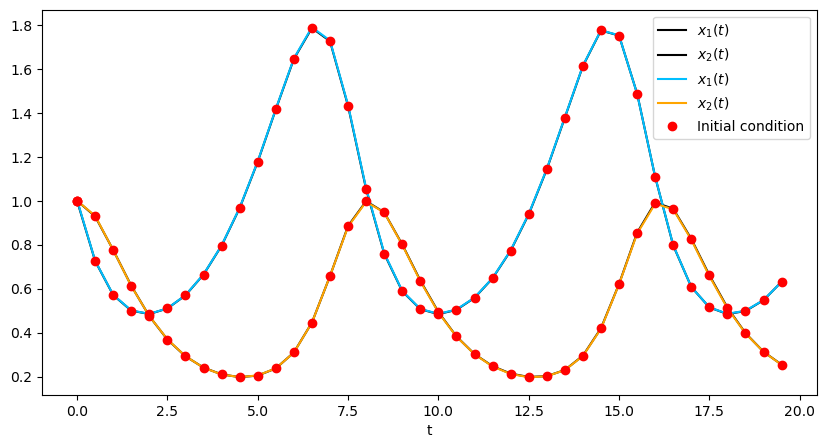

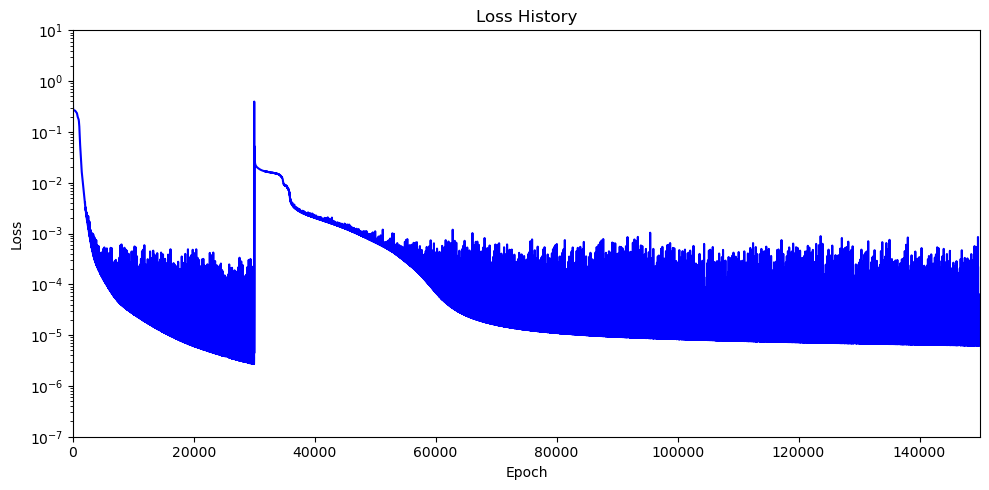

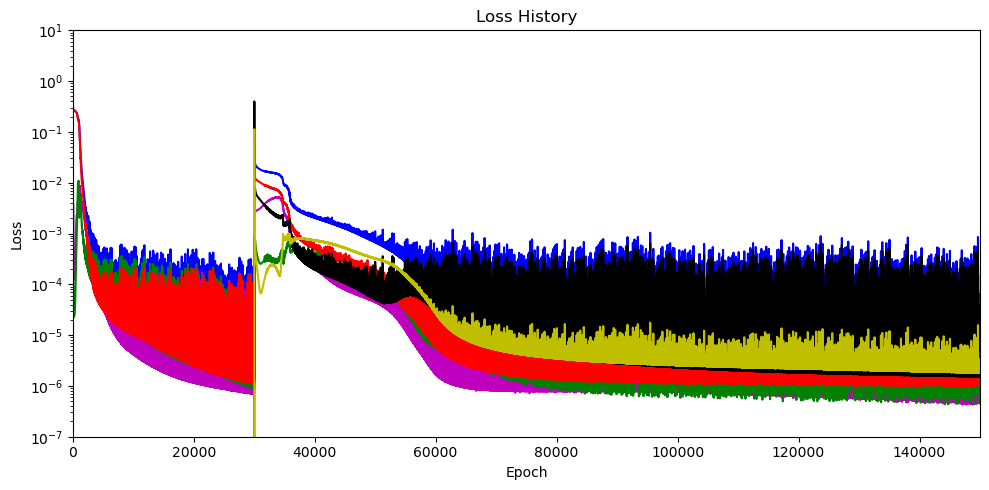

In [54]:
# Evaluate the model on the training data to see if the dynamics is improved.
model.eval()
x_pred, G_pred = model(torch.tensor(t_train,dtype=torch.float32))

# Plot the train and test data
plt.figure(figsize=(10, 5))
plt.plot(t_train, x_train[:, 0], color='black', label='$x_1(t)$')
plt.plot(t_train, x_train[:, 1], color='black', label='$x_2(t)$')
plt.plot(t_train, x_pred[:, 0].detach().numpy(), color='deepskyblue', label='$x_1(t)$')
plt.plot(t_train, x_pred[:, 1].detach().numpy(), color='orange', label='$x_2(t)$')
plt.plot(0,1,'o',color="red",label='Initial condition')
plt.plot(t_train,x_train, 'o',color='red')
plt.xlabel('t')
plt.legend()
filename = 'UPINN_Lotka_Volterra01b.png'
full_path = dirpath + filename
plt.savefig(full_path)
plt.show()

# Loss history subplot
plt.figure(figsize=(10, 5))
plt.semilogy(range(epochs+1), epoch_train_losses, 'b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.xlim([0, epochs])
plt.ylim([1e-7, 10])
plt.tight_layout()
filename = 'UPINN_Lotka_Volterra01c.png'
full_path = dirpath + filename
plt.savefig(full_path)
plt.show()

# Loss history subplot
plt.figure(figsize=(10, 5))
plt.semilogy(range(epochs+1), epoch_train_losses, 'b')
plt.semilogy(range(epochs+1), epoch_train_pde1_losses, 'm')
plt.semilogy(range(epochs+1), epoch_train_pde2_losses, 'g')
plt.semilogy(range(epochs+1), epoch_train_fun_losses, 'r')
plt.semilogy(range(epochs+1), epoch_train_pde1_losses_future, 'k')
plt.semilogy(range(epochs+1), epoch_train_pde2_losses_future, 'y')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.xlim([0, epochs])
plt.ylim([1e-7, 10])
plt.tight_layout()
filename = 'UPINN_Lotka_Volterra01d.png'
full_path = dirpath + filename
plt.savefig(full_path)
plt.show()




Let's see how the model perform on test data by predicting the solution on the test data points.

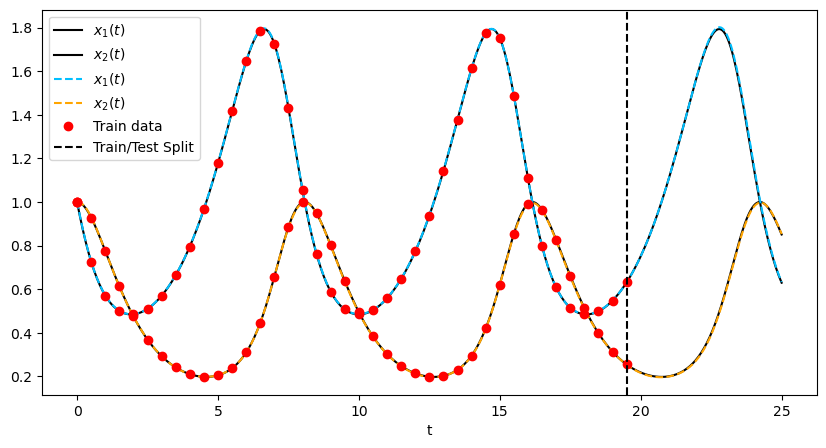

In [55]:
# Evaluate the model on the training data to see if the dynamics is improved.
model.eval()
t_choice = t_all
x_choice = x_all

# Set the interval and number of points
interval = (0, 25)
num_points = 501
# Generate random points
t_random = torch.rand(num_points) * (interval[1] - interval[0]) + interval[0]
# Sort the random points in ascending order
t_sorted = torch.sort(t_random).values

#x_pred, G_pred = model(torch.tensor(t_sorted.reshape(-1, 1),dtype=torch.float32))
x_pred, G_pred = model(torch.tensor(t_choice,dtype=torch.float32))

# Plot the train and test data
plt.figure(figsize=(10, 5))
plt.plot(t_choice, x_choice[:, 0], color='black', label='$x_1(t)$')
plt.plot(t_choice, x_choice[:, 1], color='black', label='$x_2(t)$')
plt.plot(t_choice, x_pred[:, 0].detach().numpy(), '--', color='deepskyblue', label='$x_1(t)$')
plt.plot(t_choice, x_pred[:, 1].detach().numpy(), '--', color='orange', label='$x_2(t)$')
plt.plot(t_train, x_train, 'o',color='red')
plt.plot(t_train[0], x_train[0,0], 'o',color='red',label='Train data')
plt.axvline(t_train[-1], color='k', linestyle='--', label='Train/Test Split')
plt.xlabel('t')
plt.legend()
filename = 'UPINN_Lotka_Volterra01e.png'
full_path = dirpath + filename
plt.savefig(full_path)
plt.show()




Let's also look at the trajectory of the G[u] function compared to the true one.

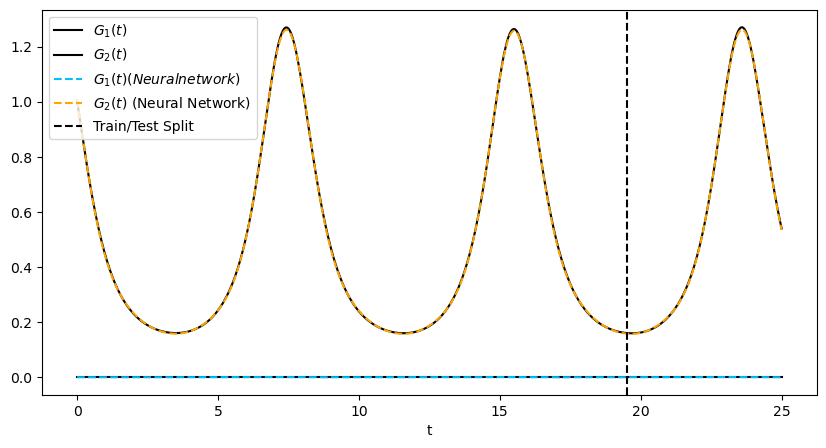

In [56]:
plt.figure(figsize=(10, 5))
plt.plot(t_choice, 0*G_pred[:, 0].detach().numpy(), color='black', label='$G_1(t)$')
plt.plot(t_choice, gamma_true*x_pred[:, 0].detach().numpy()*x_pred[:, 1].detach().numpy(), color='black', label='$G_2(t)$')
plt.plot(t_choice, G_pred[:, 0].detach().numpy(), '--', color='deepskyblue', label='$G_1(t) (Neural network)$')
plt.plot(t_choice, G_pred[:, 1].detach().numpy(), '--', color='orange', label='$G_2(t)$ (Neural Network)')
plt.axvline(t_train[-1], color='k', linestyle='--', label='Train/Test Split')
plt.xlabel('t')
plt.legend()
filename = 'UPINN_Lotka_Volterra01f.png'
full_path = dirpath + filename
plt.savefig(full_path)
plt.show()

